# Movie Revenue Prediction using Regression

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

sns.set(context='notebook', style='whitegrid', font_scale=1.2)

import random
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import re

from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression

from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     KFold, GridSearchCV)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

### Movies are scraped from Boxofficemojo.com and loaded to csv (4300+ records)

Initial cleaning is done on the movies data - removing duplicated, dropping records having null for budget/rating. We have 2204 movie records after initial cleaning and exploration

In [90]:
movie_df = pd.read_csv('Movies_rating_dataset_Sept28.csv')
print(movie_df.info())
del movie_df['link_stub']
movie_df = movie_df.dropna()
movie_df = movie_df.sort_values(by=['domestic_total_gross'], ascending=False)
movie_df.drop_duplicates(subset=["title", "domestic_total_gross", "runtime_minutes", "budget",'rank_overall','rank_g_movies','genres'], inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6360 entries, 0 to 6359
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   link_stub             6360 non-null   object 
 1   title                 6360 non-null   object 
 2   rank_g_movies         6360 non-null   int64  
 3   lifetime_gross        6360 non-null   object 
 4   rank_overall          6360 non-null   object 
 5   year                  6360 non-null   int64  
 6   domestic_total_gross  6360 non-null   int64  
 7   runtime_minutes       6229 non-null   float64
 8   rating                4377 non-null   object 
 9   release_date          6360 non-null   object 
 10  budget                3437 non-null   float64
 11  genres                6360 non-null   object 
 12  distributor           6350 non-null   object 
dtypes: float64(2), int64(3), object(8)
memory usage: 646.1+ KB
None


In [91]:
def rank_to_int(rank):
    rank_list = re.findall(r'[0-9.]', rank)
    new_rank = ""
    return int(new_rank.join(rank_list))

In [92]:
rank_overall_list = movie_df['rank_overall'].tolist()
rank_g_movies_list = movie_df['rank_g_movies'].tolist()
length = (len(rank_overall_list))

In [93]:
for i in range(length):   
    rank_overall_list[i] = rank_to_int(str(rank_overall_list[i]))
    
    rank_g_movies_list[i] = rank_to_int(str(rank_g_movies_list[i]))
    
movie_df['rank_overall'] = rank_overall_list
movie_df['rank_g_movies'] = rank_g_movies_list
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2199 entries, 509 to 5377
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 2199 non-null   object 
 1   rank_g_movies         2199 non-null   int64  
 2   lifetime_gross        2199 non-null   object 
 3   rank_overall          2199 non-null   int64  
 4   year                  2199 non-null   int64  
 5   domestic_total_gross  2199 non-null   int64  
 6   runtime_minutes       2199 non-null   float64
 7   rating                2199 non-null   object 
 8   release_date          2199 non-null   object 
 9   budget                2199 non-null   float64
 10  genres                2199 non-null   object 
 11  distributor           2199 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 223.3+ KB


In [94]:
movie_df['genres'] = movie_df['genres'].apply(lambda x: x.split()).apply(lambda y: ', '.join(y))
movie_df['genres'] = movie_df['genres'].apply(lambda x: x.split(','))
movie_df.rename(columns={'title': 'MOVIE TITLE', 'domestic_total_gross': 'LIFETIME_GROSS', 'rating':'MPAA_RATING', 'budget': 'BUDGET',
                      'runtime_minutes':'RUNTIME', 'year': 'YEAR', 'genres': 'GENRES', 'rank_g_movies':'RANK_BY_RATING', 'rank_overall':'RANK_OVERALL'}, inplace=True)

In [95]:
movie_df.shape
movie_df.info()
movie_df.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2199 entries, 509 to 5377
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MOVIE TITLE     2199 non-null   object 
 1   RANK_BY_RATING  2199 non-null   int64  
 2   lifetime_gross  2199 non-null   object 
 3   RANK_OVERALL    2199 non-null   int64  
 4   YEAR            2199 non-null   int64  
 5   LIFETIME_GROSS  2199 non-null   int64  
 6   RUNTIME         2199 non-null   float64
 7   MPAA_RATING     2199 non-null   object 
 8   release_date    2199 non-null   object 
 9   BUDGET          2199 non-null   float64
 10  GENRES          2199 non-null   object 
 11  distributor     2199 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 223.3+ KB


,MOVIE TITLE,RANK_BY_RATING,lifetime_gross,RANK_OVERALL,YEAR,LIFETIME_GROSS,RUNTIME,MPAA_RATING,release_date,BUDGET,GENRES,distributor
509,Avengers: Endgame,2,"$858,373,000",2,2019,858373000,181.0,PG-13,2019-04-24,356000000.0,"[Action, Adventure, Drama, Sci-Fi]",Walt Disney Studios Motion PicturesSee full co...
507,Avatar,3,"$760,507,625",3,2009,760507625,162.0,PG-13,2009-12-16,237000000.0,"[Action, Adventure, Fantasy, Sci-Fi]",Twentieth Century FoxSee full company informat...
5926,Titanic,6,"$659,363,944",6,1997,659363944,194.0,PG-13,1997-12-19,200000000.0,"[Drama, Romance]",Paramount PicturesSee full company information...
2562,Jurassic World,7,"$652,385,625",7,2015,652385625,124.0,PG-13,2015-06-10,150000000.0,"[Action, Adventure, Sci-Fi]",Universal PicturesSee full company information...
4708,The Avengers,8,"$623,357,910",8,2012,623357910,143.0,PG-13,2012-04-25,220000000.0,"[Action, Adventure, Sci-Fi]",Walt Disney Studios Motion PicturesSee full co...


In [96]:
movie_df.describe()
movie_df.to_csv(r'Movies_without_dummies.csv', index = False)

## Building a Simple Linear Regression Model

We have feature/target data X, y ready to go, we're nearly ready to fit and evaluate a baseline model using our current feature set. We'll need to create a train/validation split before we fit and score the model.

## Training dataset: 80%

## Holdout (test) dataset: 20%

In [102]:
X = movie_df[['BUDGET','YEAR','RUNTIME']]
Y = pd.DataFrame(movie_df['LIFETIME_GROSS'])

print(X.shape)
print(Y.shape)

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=80)
lr = LinearRegression()
lr.fit(X_train,y_train)

print('TRAIN R^2 SCORE:' , lr.score(X_train,y_train))
print('TEST R^2 SCORE:' , lr.score(X_test,y_test))

model = sm.OLS(y_train,sm.add_constant(X_train))
fit = model.fit()
fit.summary()

(2199, 3)
(2199, 1)
TRAIN R^2 SCORE: 0.33114804006034804
TEST R^2 SCORE: 0.33731612663379806


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         LIFETIME_GROSS   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     289.6
Date:                Fri, 01 Oct 2021   Prob (F-statistic):          1.03e-152
Time:                        01:34:33   Log-Likelihood:                -34260.
No. Observations:                1759   AIC:                         6.853e+04
Df Residuals:                    1755   BIC:                         6.855e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.944e+08   3.42e+08      1.738      0.082   -7.63e+07    1.27e+09
BUDGET         0.9054      0.034     26.965      0.000       0.840       0.971
YEAR       -2.963e+05    1.7e+05     -1.744      0.081    -6.3e+05     3.7e+04
RUNTIME     3.429e+05   8.97e+04      3.821      0.000    1.67e+05    5.19e+05
==============================================================================
Omnibus:                      751.380   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4438.035
Skew:                           1.921   Prob(JB):                         0.00
Kurtosis:                       9.766   Cond. No.                     1.71e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [126]:
X_pairplot = movie_df[['LIFETIME_GROSS','BUDGET','YEAR','RUNTIME']]
sns.pairplot(X_pairplot)
plt.savefig('LR_PairPlot_Target_vs_Feature')

## Feature Engineering with Linear Regression:

### Converting MPAA_Rating and Movie Genres into dummy variable (1 Hot Encoding)
Incorporating categorical features into linear regression models: we can create a new feature column for each category value, and fill these columns with 1s and 0s to indicate which category is present for each row. This method is called dummy variables or one-hot-encoding.

### Adding number of years active, Movie Month features

In [104]:
dummy_df = pd.get_dummies(movie_df,columns=['MPAA_RATING'])
del dummy_df['MPAA_RATING_Approved']
dummy_df.head(5)

,MOVIE TITLE,RANK_BY_RATING,lifetime_gross,RANK_OVERALL,YEAR,LIFETIME_GROSS,RUNTIME,release_date,BUDGET,GENRES,distributor,MPAA_RATING_G,MPAA_RATING_PG,MPAA_RATING_PG-13,MPAA_RATING_R
509,Avengers: Endgame,2,"$858,373,000",2,2019,858373000,181.0,2019-04-24,356000000.0,"[Action, Adventure, Drama, Sci-Fi]",Walt Disney Studios Motion PicturesSee full co...,0,0,1,0
507,Avatar,3,"$760,507,625",3,2009,760507625,162.0,2009-12-16,237000000.0,"[Action, Adventure, Fantasy, Sci-Fi]",Twentieth Century FoxSee full company informat...,0,0,1,0
5926,Titanic,6,"$659,363,944",6,1997,659363944,194.0,1997-12-19,200000000.0,"[Drama, Romance]",Paramount PicturesSee full company information...,0,0,1,0
2562,Jurassic World,7,"$652,385,625",7,2015,652385625,124.0,2015-06-10,150000000.0,"[Action, Adventure, Sci-Fi]",Universal PicturesSee full company information...,0,0,1,0
4708,The Avengers,8,"$623,357,910",8,2012,623357910,143.0,2012-04-25,220000000.0,"[Action, Adventure, Sci-Fi]",Walt Disney Studios Motion PicturesSee full co...,0,0,1,0


In [105]:
def get_genres_dummies(row):
    genres = row['GENRES']
    
    if type(genres) == list:
        for genre in genres:
            row[genre] = 1
            
    else:
        print(type(genres), ' : ' , genres )
    return row

In [106]:
movies_df_dummies = dummy_df.copy()

In [107]:
movies_df_dummies = movies_df_dummies.apply(get_genres_dummies, axis=1)
movies_df_dummies = movies_df_dummies.fillna(0)
movies_df_dummies

,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,...,RANK_BY_RATING,RANK_OVERALL,RUNTIME,Romance,Sci-Fi,Thriller,YEAR,distributor,lifetime_gross,release_date
509,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2,2,181.0,0.0,0.0,0.0,2019,Walt Disney Studios Motion PicturesSee full co...,"$858,373,000",2019-04-24
507,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3,3,162.0,0.0,0.0,0.0,2009,Twentieth Century FoxSee full company informat...,"$760,507,625",2009-12-16
5926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6,6,194.0,0.0,0.0,0.0,1997,Paramount PicturesSee full company information...,"$659,363,944",1997-12-19
2562,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7,7,124.0,0.0,0.0,0.0,2015,Universal PicturesSee full company information...,"$652,385,625",2015-06-10
4708,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8,8,143.0,0.0,0.0,0.0,2012,Walt Disney Studios Motion PicturesSee full co...,"$623,357,910",2012-04-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,983,4565,114.0,0.0,0.0,0.0,1998,Walt Disney Studios Motion PicturesSee full co...,"$12,069,719",1998-10-09
1504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,984,4566,106.0,0.0,0.0,0.0,2010,CBS FilmsSee full company information\n\n,"$12,068,313",2010-01-22
1851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,989,4595,84.0,0.0,0.0,0.0,2011,Twentieth Century FoxSee full company informat...,"$11,862,398",2011-08-11
2935,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,991,4603,90.0,0.0,0.0,0.0,2008,Twentieth Century FoxSee full company informat...,"$11,803,254",2008-07-09


In [108]:
dummy_df['YEARS_ACTIVE'] = 2021 - X.YEAR
movies_df_dummies['YEARS_ACTIVE'] = 2021 - X.YEAR
movies_df_dummies['RELEASE_MONTH'] = pd.DatetimeIndex(dummy_df['release_date']).month

In [109]:
movies_final_df = movies_df_dummies
movies_final_df.drop(['release_date','lifetime_gross','GENRES','RANK_BY_RATING','RANK_OVERALL','MOVIE TITLE','distributor'],axis=1, inplace=True)
movies_final_df.info()
movies_final_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2199 entries, 509 to 5377
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0    Adventure         2199 non-null   float64
 1    Animation         2199 non-null   float64
 2    Biography         2199 non-null   float64
 3    Comedy            2199 non-null   float64
 4    Crime             2199 non-null   float64
 5    Documentary       2199 non-null   float64
 6    Drama             2199 non-null   float64
 7    Family            2199 non-null   float64
 8    Fantasy           2199 non-null   float64
 9    History           2199 non-null   float64
 10   Horror            2199 non-null   float64
 11   Music             2199 non-null   float64
 12   Musical           2199 non-null   float64
 13   Mystery           2199 non-null   float64
 14   Romance           2199 non-null   float64
 15   Sci-Fi            2199 non-null   float64
 16   Sport             219

,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,...,MPAA_RATING_R,Musical,Mystery,RUNTIME,Romance,Sci-Fi,Thriller,YEAR,YEARS_ACTIVE,RELEASE_MONTH
509,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0.0,0.0,181.0,0.0,0.0,0.0,2019,2,4
507,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0.0,0.0,162.0,0.0,0.0,0.0,2009,12,12
5926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,194.0,0.0,0.0,0.0,1997,24,12
2562,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,124.0,0.0,0.0,0.0,2015,6,6
4708,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,143.0,0.0,0.0,0.0,2012,9,4


In [110]:
X_features_df = movies_final_df
X_features = X_features_df.columns.difference(['LIFETIME_GROSS'])
print(X_features)
Y_target = ['LIFETIME_GROSS']
Y_target

Index([' Adventure', ' Animation', ' Biography', ' Comedy', ' Crime',
       ' Documentary', ' Drama', ' Family', ' Fantasy', ' History', ' Horror',
       ' Music', ' Musical', ' Mystery', ' Romance', ' Sci-Fi', ' Sport',
       ' Thriller', ' War', ' Western', 'Action', 'Adventure', 'Animation',
       'BUDGET', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'Horror', 'MPAA_RATING_G', 'MPAA_RATING_PG',
       'MPAA_RATING_PG-13', 'MPAA_RATING_R', 'Musical', 'Mystery',
       'RELEASE_MONTH', 'RUNTIME', 'Romance', 'Sci-Fi', 'Thriller', 'YEAR',
       'YEARS_ACTIVE'],
      dtype='object')


['LIFETIME_GROSS']

In [111]:
X = movies_final_df[X_features]
Y = pd.DataFrame(movies_final_df['LIFETIME_GROSS'])

print(X.shape)
print(Y.shape)

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=80)
lr = LinearRegression()
lr.fit(X_train,y_train)

print('TRAIN R^2 SCORE:', lr.score(X_train,y_train))
print('TEST R^2 SCORE:', lr.score(X_test,y_test))

model = sm.OLS(y_train,sm.add_constant(X_train))
fit = model.fit()

fit.summary()

(2199, 45)
(2199, 1)
TRAIN R^2 SCORE: 0.4145097471188087
TEST R^2 SCORE: 0.40466466149155955


## Regularized Linear Regression 

## Standardizing the inputs
Standardization is the process of putting different variables on the same scale. A variable is standardized by subtracting from it its sample mean and by dividing it by its standard deviation. After being standardized, the variable has zero mean and unit standard deviation

In [112]:
X_tran_ip = X
Y_tran_ip = Y

scaler_X = StandardScaler()
scaler_X.fit(X_tran_ip)
X_tran = scaler_X.transform(X_tran_ip)
X_tran

array([[ 2.14701977, -0.40281777, -0.06758917, ..., -0.04773827,
         1.25947979, -1.25947979],
       [ 2.14701977, -0.40281777, -0.06758917, ..., -0.04773827,
         0.25549369, -0.25549369],
       [-0.4657619 , -0.40281777, -0.06758917, ..., -0.04773827,
        -0.94928964,  0.94928964],
       ...,
       [-0.4657619 , -0.40281777, -0.06758917, ..., -0.04773827,
         0.45629091, -0.45629091],
       [-0.4657619 , -0.40281777, -0.06758917, ..., -0.04773827,
         0.15509508, -0.15509508],
       [-0.4657619 , -0.40281777, -0.06758917, ..., -0.04773827,
         0.45629091, -0.45629091]])

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X_tran,Y, test_size=0.2, random_state=80)

model = LinearRegression()
model.fit(X_train,y_train)

print('TRAIN R^2 SCORE:', model.score(X_train,y_train))
print('TEST R^2 SCORE:', model.score(X_test,y_test))

model_ols = sm.OLS(y_train,sm.add_constant(X_train))
fit = model_ols.fit()

fit.summary()

TRAIN R^2 SCORE: 0.41450795832879883
TEST R^2 SCORE: -1.0930487016995294e+20


### Cross Validation using K-fold

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=80)

# Notice that we are splitting the X_train data into 5 Folds
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

linear_model = LinearRegression()

scores = cross_val_score(linear_model, X_train, y_train, cv=kfold)
print(scores)
print("Linear Reg Mean Score: ", np.mean(scores))

# Build the Model
linear_model.fit(X_train, y_train)


print('TRAIN R^2 SCORE:', linear_model.score(X_train,y_train))
print('TEST R^2 SCORE:', linear_model.score(X_test,y_test))

[0.3888253  0.38139825 0.34166819 0.41272629 0.3761775 ]
Linear Reg Mean Score:  0.380159106637025
TRAIN R^2 SCORE: 0.4145097471188087
TEST R^2 SCORE: 0.40466466149155955


# Fitted vs. Actual

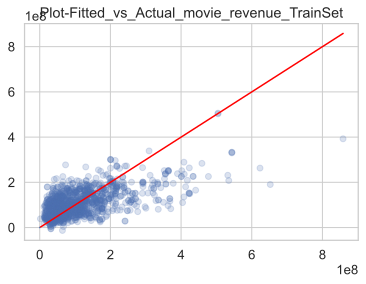

In [149]:
# Fitted vs. Actual
y_train_pred = linear_model.predict(X_train)

plt.scatter(y_train, y_train_pred, alpha=0.2)
plt.plot(y_train, y_train, color = 'red')
# plt.scatter(x, y_actual)

plt.plot([0, 400], [0, 400])
plt.title("Plot-Fitted_vs_Actual_movie_revenue_TrainSet")
plt.savefig('Plot-Fitted_vs_Actual_movie_revenue_TrainSet')

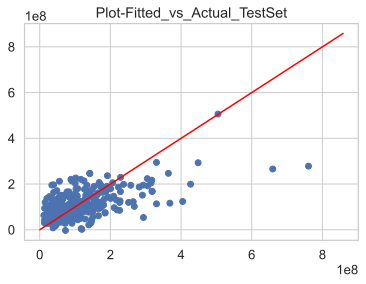

In [150]:
# Fitted vs. Actual
y_test_pred = linear_model.predict(X_test)
plt.plot(y_train, y_train, color = 'red')
plt.scatter(y_test, y_test_pred)
plt.plot([0, 400], [0, 400])
plt.title("Plot-Fitted_vs_Actual_TestSet")
plt.savefig('Plot-Fitted_vs_Actual_TestSet')

### Plot Residuals vs. predicted


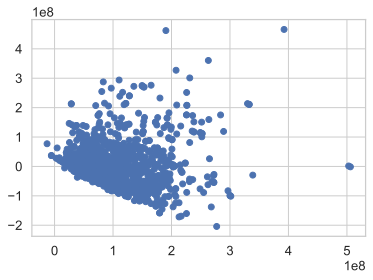

In [153]:
# Plot Residuals vs. predicted

linear_model = y_train - y_train_pred

plt.scatter(y_train_pred, linear_model)
plt.plot([0,400], [0, 0])
# plt.title("Residuals vs. Predictions")
plt.savefig('Residuals vs. Predictions')

## Regularization - Exploring the Behavior of LASSO vs. Ridge Regularization

Regularized Linear Regression introduces a regularization strength parameter that says how strongly we want to penalize the coefficients.

### LASSO Model


In [119]:
#Lasso Model

X_train, X_test, y_train, y_test = train_test_split(X_tran,Y, test_size=0.2, random_state=80)

print("Lasso Model:")
params = {
    "alpha": np.logspace(-4, -.1, 20)
}

grid_est = GridSearchCV(Lasso(), param_grid=params, cv=kfold, 
                        return_train_score=False)
grid_est.fit(X_train, y_train)
df = pd.DataFrame(grid_est.cv_results_)
df["alpha"] = df.params.apply(lambda val: val["alpha"])
print(df.mean_test_score)
plt.plot(np.log(df.alpha), df.mean_test_score);

Lasso Model:


C:\Users\vyasc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.60898168836415e+17, tolerance: 963540132241020.6
  model = cd_fast.enet_coordinate_descent(
C:\Users\vyasc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.277496728056095e+17, tolerance: 1030164304844550.2
  model = cd_fast.enet_coordinate_descent(
C:\Users\vyasc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.713937878407245e+17, tolerance: 1071450858817735.1
  model = cd_fast.enet_coordinate_descent(
C:\Users\vyasc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conv

0     0.379343
1     0.379343
2     0.379343
3     0.379343
4     0.379343
5     0.379343
6     0.379343
7     0.379343
8     0.379343
9     0.379343
10    0.379343
11    0.379343
12    0.379343
13    0.379343
14    0.379343
15    0.379343
16    0.379343
17    0.379343
18    0.379343
19    0.379343
Name: mean_test_score, dtype: float64


C:\Users\vyasc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.04805567978346e+17, tolerance: 1273502935804444.0
  model = cd_fast.enet_coordinate_descent(


In [120]:
grid_est.best_estimator_

Lasso(alpha=0.7943282347242815)

In [121]:
params['alpha']

array([1.00000000e-04, 1.60421716e-04, 2.57351270e-04, 4.12847324e-04,
       6.62296762e-04, 1.06246783e-03, 1.70442913e-03, 2.73427446e-03,
       4.38637001e-03, 7.03669004e-03, 1.12883789e-02, 1.81090112e-02,
       2.90507865e-02, 4.66037703e-02, 7.47625680e-02, 1.19935395e-01,
       1.92402418e-01, 3.08655261e-01, 4.95150067e-01, 7.94328235e-01])

In [122]:
# for alpha in params['alpha']: // bicking the best alpha from the aplha array
model_lasso = Lasso(alpha=0.00066)
model_lasso.fit(X_train, y_train)
print('Selected alpha is: ', 0.00066)
pred_train_lasso= model_lasso.predict(X_train)

print('\n RMSE ERROR IS: ', np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print('\n R^2 WITH LASSO IS: ', r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(X_test)

print('\n RMSE ERROR ON TEST DATA IS: ', np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print('\n R^2 WITH LASSO ON TEST DATA IS:', r2_score(y_test, pred_test_lasso))

Selected alpha is:  0.00066

 RMSE ERROR IS:  65106880.943241164

 R^2 WITH LASSO IS:  0.41450974711880895

 RMSE ERROR ON TEST DATA IS:  65725821.6349093

 R^2 WITH LASSO ON TEST DATA IS: 0.4045220907416476


C:\Users\vyasc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.048070826301404e+17, tolerance: 1273502935804444.0
  model = cd_fast.enet_coordinate_descent(


Selected alpha is:  0.00066

 RMSE ERROR IS:  65106880.94

 R^2 WITH LASSO IS:  0.4145

 RMSE ERROR ON TEST DATA IS:  65725821.63

 R^2 WITH LASSO ON TEST DATA IS: 0.4045

In [83]:
print(X_features)
model_lasso.coef_

Index([' Adventure', ' Animation', ' Biography', ' Comedy', ' Crime',
       ' Documentary', ' Drama', ' Family', ' Fantasy', ' History', ' Horror',
       ' Music', ' Musical', ' Mystery', ' Romance', ' Sci-Fi', ' Sport',
       ' Thriller', ' War', ' Western', 'Action', 'Adventure', 'Animation',
       'BUDGET', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'Horror', 'MPAA_RATING_G', 'MPAA_RATING_PG',
       'MPAA_RATING_PG-13', 'MPAA_RATING_R', 'Musical', 'Mystery',
       'RELEASE_MONTH', 'RUNTIME', 'Romance', 'Sci-Fi', 'Thriller', 'YEAR',
       'YEARS_ACTIVE'],
      dtype='object')


array([ 1.15854968e+06,  1.22199082e+07,  5.66682404e+05,  2.15334453e+06,
        5.61311800e+05, -1.98360323e+06, -3.52280622e+06, -2.69580494e+06,
       -3.32087715e+06, -5.27610457e+06,  4.10436652e+05,  3.62885834e+06,
        8.61554220e+06, -1.34002101e+06, -2.97375547e+06, -9.45963702e+05,
       -2.02382230e+06, -7.55363373e+06, -2.33680802e+06, -5.26007834e+06,
        7.19988628e+06,  8.51032368e+06,  3.36697771e+06,  3.90225894e+07,
        1.52375049e+06,  1.01968835e+07,  5.03632512e+06,  4.45893220e+05,
        4.67509955e+06,  1.14883437e+07,  9.37798496e+05,  8.72810645e+06,
        2.24315962e+06, -2.92246419e+06,  3.36844644e+06, -1.96682310e+06,
        4.97687410e+06,  2.14780931e+06, -2.77622451e+06,  1.90510148e+07,
        1.07952927e+05,  8.05385695e+05,  8.19879550e+05, -4.68952044e+04,
        2.07563275e-08])

### RIDGE MODEL

Ridge Model:


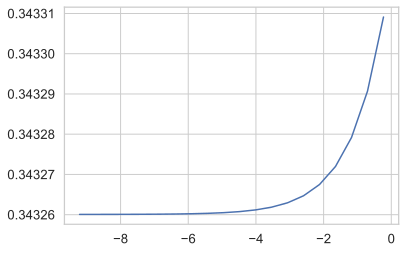

In [84]:
print("Ridge Model:")
params = {
    "alpha": np.logspace(-4, -.1, 20)
}

grid_est = GridSearchCV(Ridge(), param_grid=params, cv=kfold, 
                        return_train_score=False)
grid_est.fit(X_train, y_train)
df = pd.DataFrame(grid_est.cv_results_)
df["alpha"] = df.params.apply(lambda val: val["alpha"])
plt.plot(np.log(df.alpha), df.mean_test_score);

In [129]:
# for alpha in params['alpha']: // bicking the best alpha from the aplha array
model_ridge = Ridge(alpha=0.00066)
model_ridge.fit(X_train, y_train)
print('Selected alpha is: ', 0.00066)
pred_train_ridge= model_ridge.predict(X_train)

print('\n RMSE ERROR IS: ', np.sqrt(mean_squared_error(y_train,pred_train_ridge)))
print('\n R^2 WITH RIDGE IS: ', r2_score(y_train, pred_train_ridge))

pred_test_ridge= model_ridge.predict(X_test)

print('\n RMSE ERROR ON TEST DATA IS: ', np.sqrt(mean_squared_error(y_test,pred_test_ridge))) 
print('\n R^2 WITH RIDGE ON TEST DATA IS:', r2_score(y_test, pred_test_ridge))

Selected alpha is:  0.00066

 RMSE ERROR IS:  65106880.94324491

 R^2 WITH RIDGE IS:  0.41450974711874156

 RMSE ERROR ON TEST DATA IS:  65728855.700441934

 R^2 WITH RIDGE ON TEST DATA IS: 0.40446711202380803


### Final Thoughts

We have performed Linear Regression; Lasso and Ridge Regression with Standardized inputs.
In the LASSO, we penalize the sum of the absolute values of the coefficients 
and in Ridge Regression we penalize the sum of the squares of the coefficients.

With our business needs strong inclination toward interpretability with small set of variables, hence we are using LASSO.